<a href="https://colab.research.google.com/github/pinilDissanayaka/Pneumonia-Detection-using-Deep-Learning/blob/main/Pneumonia_Detection_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [2]:
! kaggle datasets download tolgadincer/labeled-chest-xray-images

 99% 1.16G/1.17G [00:10<00:00, 154MB/s]
100% 1.17G/1.17G [00:10<00:00, 117MB/s]


In [3]:
! unzip /content/labeled-chest-xray-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/NORMAL-2558319-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2558319-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2559035-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2559035-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2565226-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2568157-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2597757-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2597757-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-263932-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2646645-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2646923-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2655558-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2659844-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2675017-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2675017-00

In [4]:
!pip install livelossplot
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 4.8 MB/s eta 0:00:00


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import cv2 as cv
from glob import glob
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D, BatchNormalization, Activation, MaxPool2D, GlobalAvgPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from livelossplot import PlotLossesKerasTF
import visualkeras

%matplotlib inline

import warnings
warnings.filterwarnings(action = 'ignore')

In [6]:
MAIN_DIR = '/content/chest_xray'

In [7]:
glob(MAIN_DIR + '/*')

['/content/chest_xray/test', '/content/chest_xray/train']

In [8]:
TRAIN_DIR = glob(MAIN_DIR + '/*')[1]
TEST_DIR = glob(MAIN_DIR + '/*')[0]


print(f"Training directory : {TRAIN_DIR}")
print(f"Testing directory : {TEST_DIR}")

Training directory : /content/chest_xray/train
Testing directory : /content/chest_xray/test


In [9]:
TRAIN_CATEGORIES = os.listdir(TRAIN_DIR)
TESTING_CATEGORIES = os.listdir(TEST_DIR)


print(f"Trainging categories : {TRAIN_CATEGORIES}")
print(f"Testing categories : {TESTING_CATEGORIES}")


OUT_SIZE = len(TRAIN_CATEGORIES)

Trainging categories : ['PNEUMONIA', 'NORMAL']
Testing categories : ['PNEUMONIA', 'NORMAL']


In [10]:
TRAIN_CATEGORIES == TESTING_CATEGORIES

True

In [11]:
for i in glob(MAIN_DIR + '/*'):
  path = glob(i + '/*')
  for j in path:
    imgCount = len(os.listdir(j))
    print(f"{j} has {imgCount} images.")
  print('\n')

/content/chest_xray/test/PNEUMONIA has 390 images.
/content/chest_xray/test/NORMAL has 234 images.


/content/chest_xray/train/PNEUMONIA has 3883 images.
/content/chest_xray/train/NORMAL has 1349 images.




TRAINING NORMAL


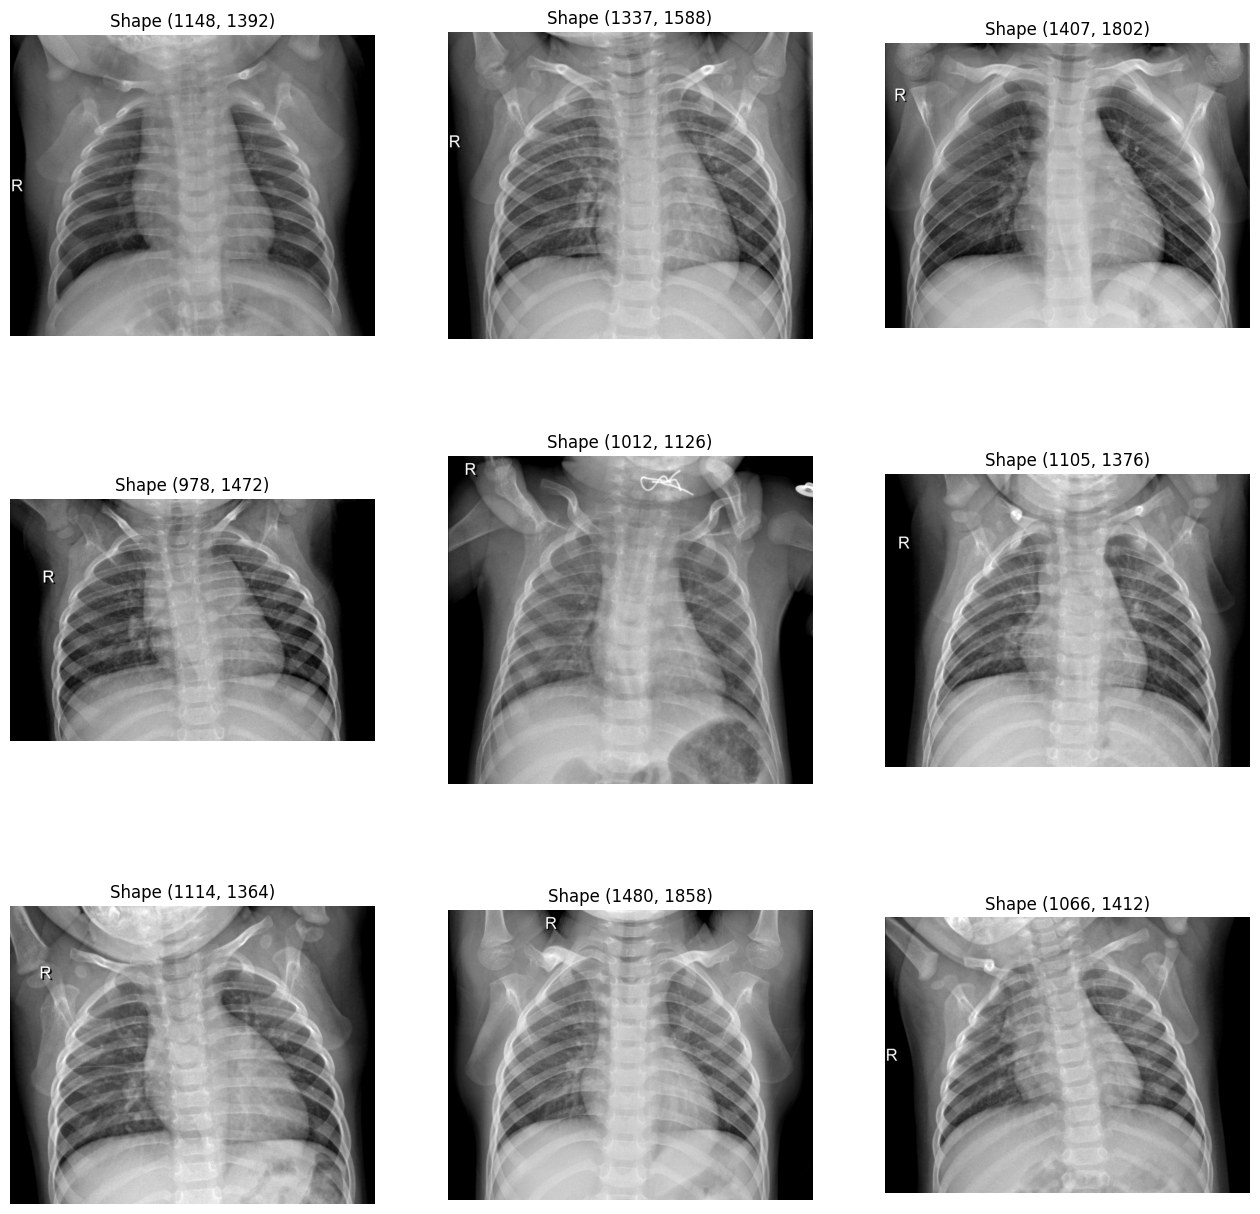

In [12]:
path = random.choices(list(glob(TRAIN_DIR + '/NORMAL/*')), k = 9)
plt.figure(figsize = (16, 16))
print('TRAINING NORMAL')
j = 1
for i in path:
  img = plt.imread(i)
  plt.subplot(3, 3, j)
  plt.imshow(img, cmap='gray')
  plt.title(f"Shape {img.shape}")
  plt.axis('off')
  j = j +1

TRAINING PNEUMONIA


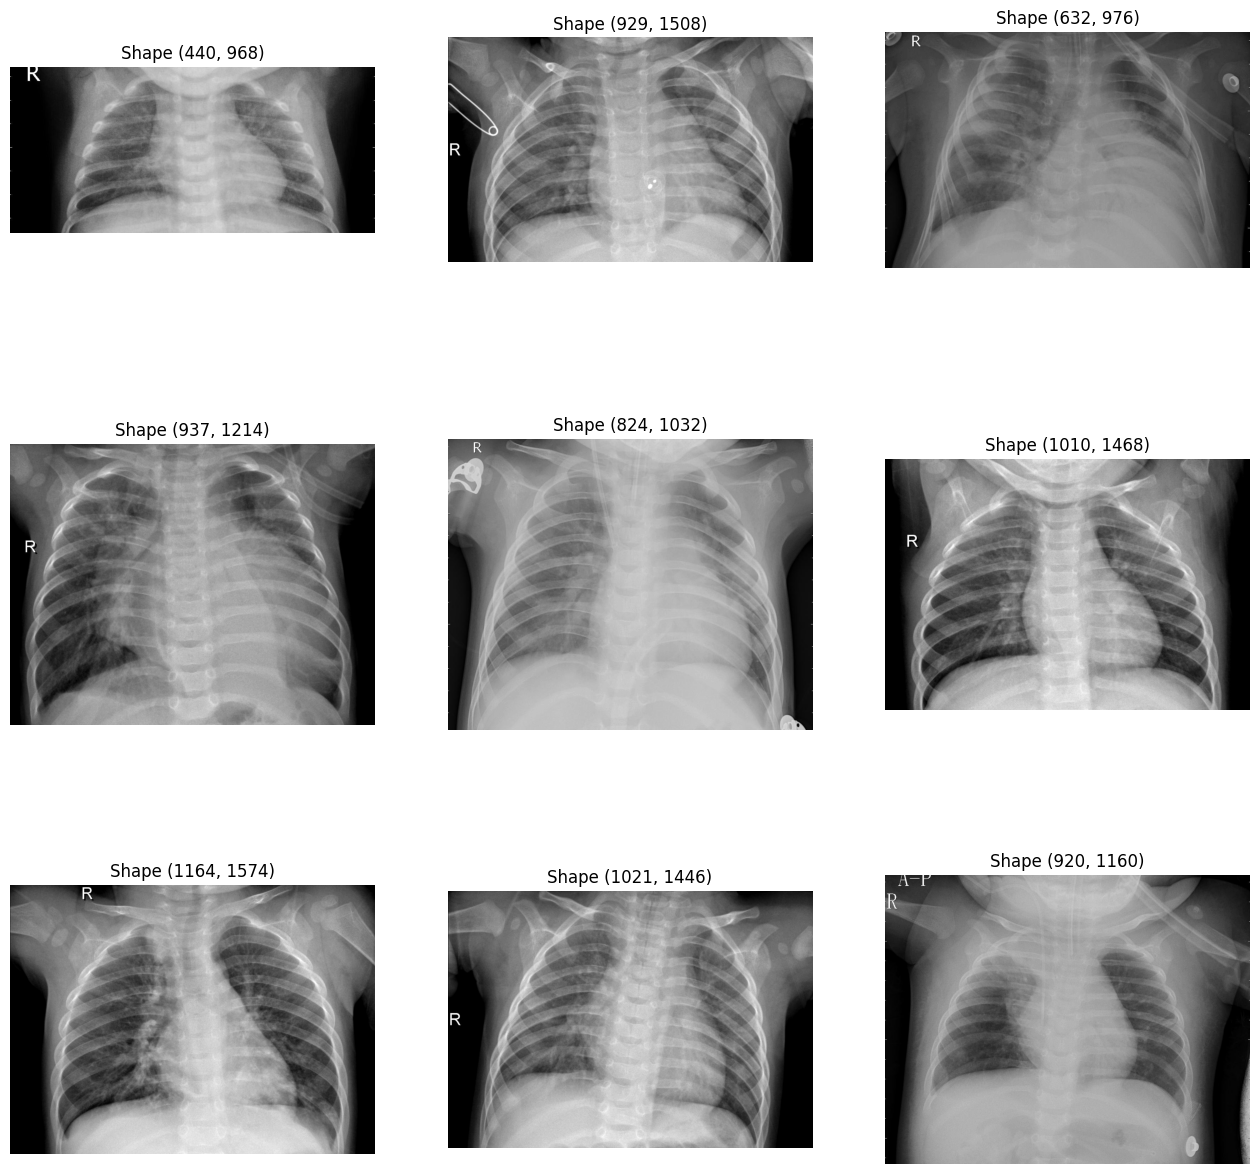

In [13]:
path = random.choices(list(glob(TRAIN_DIR + '/PNEUMONIA/*')), k = 9)
plt.figure(figsize = (16, 16))
print('TRAINING PNEUMONIA')
j = 1
for i in path:
  img = plt.imread(i)
  plt.subplot(3, 3, j)
  plt.imshow(img, cmap='gray')
  plt.title(f"Shape {img.shape}")
  plt.axis('off')
  j = j +1

In [14]:
rescale = 1./255
TARGET_SIZE = [150, 150]
INPUT_SHAPE = TARGET_SIZE + [3]
batch_size = 64
class_mode = "binary"


train_datagen = ImageDataGenerator(
    rescale=rescale,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=TARGET_SIZE,
    class_mode=class_mode,
    batch_size=batch_size,
    shuffle=True)

test_datagen = ImageDataGenerator(rescale=rescale)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=TARGET_SIZE,
    class_mode=class_mode,
    batch_size= batch_size,
    shuffle = False)

Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [15]:
TRAINING_STEPS = train_generator.n // train_generator.batch_size
VALIDATION_STEPS = test_generator.n // test_generator.batch_size


print(f"Training epoch has {TRAINING_STEPS} steps.")
print(f"Validation epoch has {VALIDATION_STEPS} steps.")

Training epoch has 81 steps.
Validation epoch has 9 steps.


In [16]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [17]:
OUT_DICT = {v : k for k, v in train_generator.class_indices.items()}


OUT_DICT

{0: 'NORMAL', 1: 'PNEUMONIA'}

In [18]:
earlyStopping = EarlyStopping(monitor='val_loss',
                              patience=2,
                              verbose=1)

reduceLr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=2,
                              min_lr=0.000001,
                              model='auto')

modelCheck = ModelCheckpoint("model_weights.h5",
                             monitor="val_accuracy",
                             save_weights_only=True,
                             mode="max",
                             verbose=1)


callBacks = [earlyStopping, reduceLr, modelCheck, PlotLossesKerasTF()]

In [22]:
def get_conv_model():
    model = Sequential()
    model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = INPUT_SHAPE))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(GlobalAvgPool2D())
    model.add(Dense(units = 128 , activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1 , activation = 'sigmoid'))

    print(model.summary())

    return model

In [23]:
model = get_conv_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      896       
                                                                 
 batch_normalization_1 (Bat  (None, 150, 150, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_2 (Bat  (None, 75, 75, 64)       

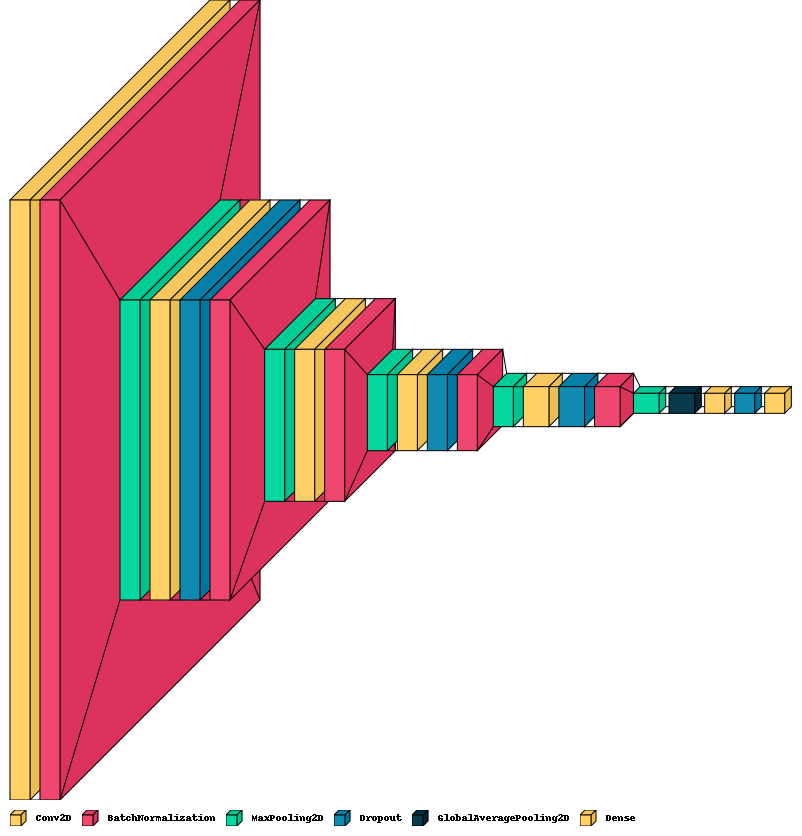

In [24]:
visualkeras.layered_view(model, legend=True)

In [25]:
model.compile(optimizer= 'rmsprop', loss= 'binary_crossentropy', metrics=['accuracy'])

In [ ]:
model_history = model.fit_generator(
    train_generator,
    steps_per_epoch = TRAINING_STEPS,
    epochs=100,
    verbose=1,
    callbacks=callBacks,
    validation_data=test_generator,
    validation_steps=VALIDATION_STEPS)

Epoch 1/100
49/81 [=================>............] - ETA: 26s - loss: 0.3805 - accuracy: 0.8463

In [ ]:
model_history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

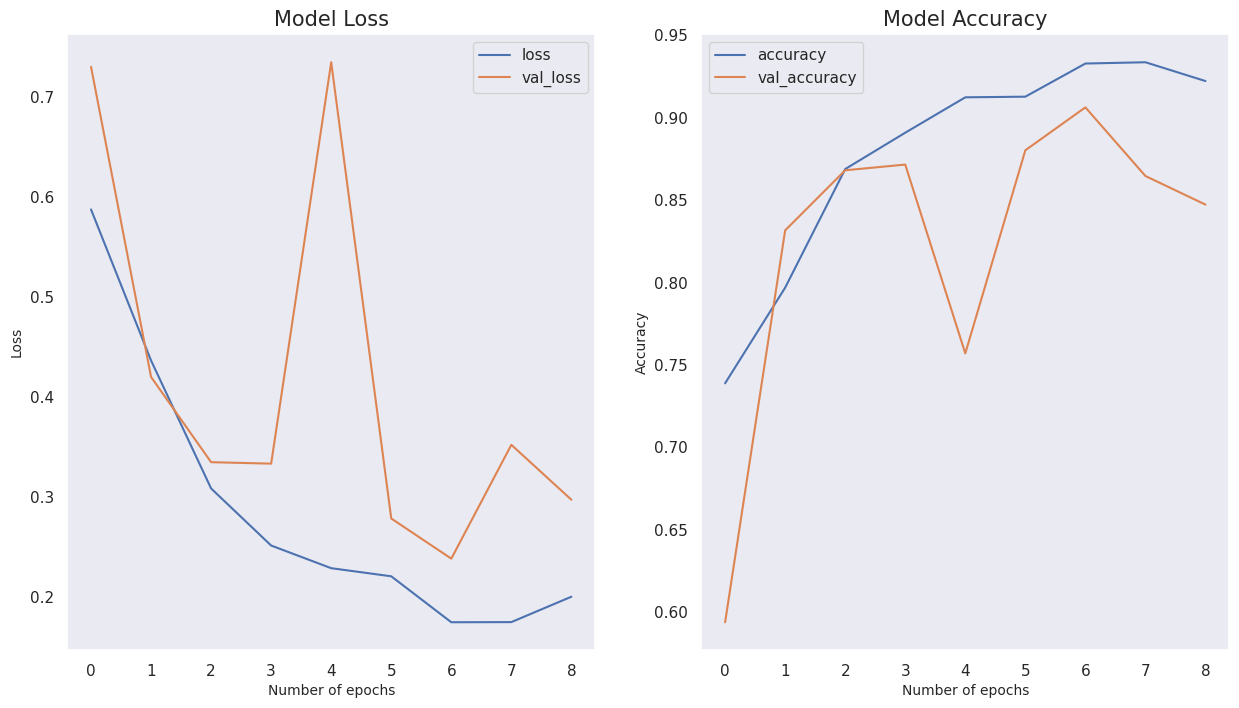

In [ ]:
sns.set()
plt.figure(figsize = (15, 8))
plt.subplot(1, 2, 1)
plt.title('Model Loss', fontsize=15)
plt.plot(model_history.history['loss'], label = 'loss')
plt.plot(model_history.history['val_loss'], label = 'val_loss')
plt.grid(False)
plt.legend()
plt.xlabel("Number of epochs", fontsize=10)
plt.ylabel("Loss", fontsize=10)

plt.subplot(1, 2, 2)
plt.title('Model Accuracy', fontsize=15)
plt.plot(model_history.history['accuracy'], label = 'accuracy')
plt.plot(model_history.history['val_accuracy'], label = 'val_accuracy')
plt.grid(False)
plt.legend()
plt.xlabel("Number of epochs", fontsize=10)
plt.ylabel("Accuracy", fontsize=10)

plt.show()

In [ ]:
print("Results")
result  = model.evaluate_generator(test_generator, steps= VALIDATION_STEPS, verbose=1)

print("%s%.2f  "% ("Loss     : ", result[0]))
print("%s%.2f%s"% ("Accuracy : ", result[1]*100, "%"))

Results
9/9 [==============================] - 6s 646ms/step - loss: 0.2974 - accuracy: 0.8472
Loss     : 0.30  
Accuracy : 84.72%


In [ ]:
y_pred = model.predict_generator(test_generator, verbose=1)

y_true = test_generator.classes

10/10 [==============================] - 5s 426ms/step


In [ ]:
OUT_DICT

{0: 'NORMAL', 1: 'PNEUMONIA'}

In [ ]:
y_pred1 = []

for i in y_pred:
  if i < 0.5:
    y_pred1.append(0)
  else:
    y_pred1.append(1)

In [ ]:
classificationReport = classification_report(y_true= y_true, y_pred = y_pred1)

print(classificationReport)

              precision    recall  f1-score   support

           0       0.98      0.64      0.77       234
           1       0.82      0.99      0.90       390

    accuracy                           0.86       624
   macro avg       0.90      0.81      0.83       624
weighted avg       0.88      0.86      0.85       624



In [ ]:
classes = OUT_DICT.values()
classes

dict_values(['NORMAL', 'PNEUMONIA'])

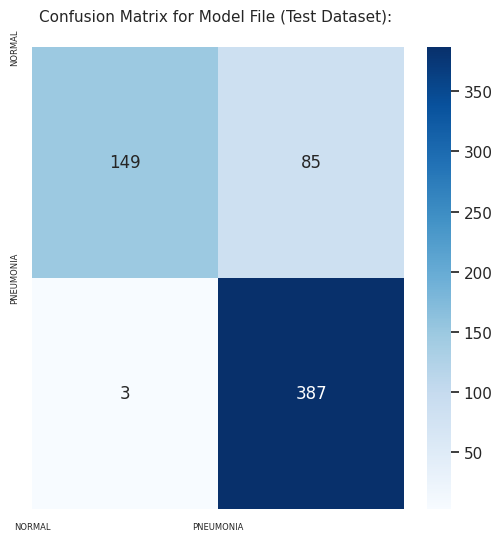

In [ ]:
sns.set()
plt.figure(figsize = (6, 6))
plt.title("Confusion Matrix for Model File (Test Dataset): \n", fontsize=11)
sns.heatmap(data = confusion_matrix(y_true= y_true, y_pred= y_pred1), annot= True, fmt = 'g', cmap="Blues")
plt.xticks(range(len(classes)), classes, fontsize=6)
plt.yticks(range(len(classes)), classes, fontsize=6)
plt.show()